The notebook demonstrates how to solve the motions of a double pendulum. <br>

Here we provide the solutions that you can depend on to derive the first-order ODEs for the numerical implementation. For detailed derivations, you may refer to the link provided in the end of this Jupyter Notebook. <br>

A pendulum describes a mechanical system that a mass that swings around a fixed end through the link of a rod governed by the gravity, tensions in the rod and kinematics. A double pendulum is a mechanical system that contains two pendulums attached end to end. For small motions, it is a simple linear system, while for large motions, the system is chaotic.

The motions of the two masses in the double pendulum follow:
\begin{align}
\ddot{\theta_1} = \frac{-g(2m_1+m_2)sin\theta_1 - m_2 g sin(\theta_1 - 2\theta_2) - 2sin(\theta_1 - \theta_2) m_2 (\dot{\theta_2}^2 L_2 + \dot{\theta_1}^2 L_1 cos(\theta_1 - \theta_2))}{L_1 (2m_1 + m_2 - m_2 cos(2 \theta_1 - 2 \theta_2))} \\
\ddot{\theta_2} = \frac{2 sin(\theta_1 - \theta_2)(\dot{\theta_1}^2 L_1 (m_1 + m_2) + g(m_1+m_2)cos\theta_1 + \dot{\theta_2}^2 L_2 m_2 cos(\theta_1 - \theta_2))}{L_2(2 m_1 + m_2 - m_2 cos(2 \theta_1 - 2 \theta_2))}
\end{align}
where $\theta_1$ and $\theta_2$ are angular positions of the upper and lower rods relative to the vertical axis, $m_1$ and $m_2$ are the masses of the upper and lower masses, $L_1$ and $L_2$ are the lengths of upper and lower rods, and $g$ is the gravitational constant. <br>

To solve the second-order ordinary differential equation system, we can reduce it to a system of first-order ODEs and apply our previouly developed numerical algorithms. 

Could you derive the system of first-order ODEs we need for numerical implementation?

In [1]:
%pip install -q ipywidgets matplotlib numpy scipy pandas
import numpy  as np
import pandas as pd
import ode    as odeLib        # our ODE routines
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from collections import deque
from   math                 import radians, sin, cos, pi
from   scipy                import integrate
from   ipywidgets           import *
from   IPython.display      import display

Note: you may need to restart the kernel to use updated packages.


In [2]:
#
# define probelm
#
class parameters:                 # parameters for functions, default values
    l1 = 1.
    l2 = 1.
    m1 = 2.
    m2 = 2.
    g  = 9.8
# 
# define functions for ODE solvres, need to be in f(t,x,par) format
#
# damping harmonic oscillator, dx/dt for dotx and x.

ndim   = 4
vlabel = ["the1", "the2", "w1", "w2"]            # labels for the variables
# All the angles are in radians.
# the1: the angular position of mass 1. 
# the2: the angular position of mass 2.
# w1  : the angular velocity of mass 1.
# w2  : the angular velocity of mass 2.

def f0(t,x,par): # dthe1/dt = w1
    return x[2]
def f1(t,x,par): # dthe2/dt = w2
    return x[3]
def f2(t,x,par): # dw1/dt  
    g  = par.g
    m1 = par.m1
    m2 = par.m2
    l1 = par.l1
    l2 = par.l2
    
    numerator   = -g*(2*m1+m2)*sin(x[0])-m2*g*sin(x[0]-2*x[1]) - 2*sin(x[0]-x[1])*m2*(x[3]*x[3]*l2 + x[2]*x[2]*l1*cos(x[0]-x[1]))
    denominator = l1*(2*m1+m2-m2*cos(2*x[0]-2*x[1]))
    return numerator/denominator

def f3(t,x,par): # dw2/dt
    g  = par.g
    m1 = par.m1
    m2 = par.m2
    l1 = par.l1
    l2 = par.l2
    
    numerator   = 2*sin(x[0]-x[1])*(x[2]*x[2]*l1*(m1+m2) + g*(m1+m2)*cos(x[0]) + x[3]*x[3]*l2*m2*cos(x[0]-x[1]))
    denominator = l2*(2*m1 + m2 - m2*cos(2*x[0] - 2*x[1]))
    
    return numerator/denominator

def xy(theta1, theta2, par):
    # given the time series of theta1 and theta2 and l1 and l2, 
    # return locations of the two masses as a function of time.
    m1 = par.m1
    m2 = par.m2
    l1 = par.l1
    l2 = par.l2
    
    x1 = l1*np.sin(theta1)
    y1 = -l1*np.cos(theta1)
    x2 = x1 + l2*np.sin(theta2)
    y2 = y1 - l2*np.cos(theta2)
    
    return x1,y1,x2,y2

def ode_solver(time, xInit, method, ndim, par):
    # method supports three options
    # - 'eular'
    # - 'midpoint'
    # - 'runge_kutta'
    
    nstep = len(time)
    xout  = np.empty((nstep,ndim))
    
    hs    = time[1] - time[0]
    xtmp  = xInit
    f     = [f0, f1, f2, f3]
    for i, t in enumerate(time):
        xout[i][:] = xtmp
        if method  == 'euler':
            xtmp   = odeLib.euler(t,xtmp,f,ndim,hs,par)
        elif method == 'midpoint':
            xtmp   = odeLib.midpoint(t,xtmp,f,ndim,hs,par)
        elif method == 'runge_kutta':
            xtmp   = odeLib.runge_kutta(t,xtmp,f,ndim,hs,par)

    return xout

In [3]:
def main(l1,l2,m1,m2, xi1,xi2,xi3,xi4, method = "euler", plot = True):
    
    Nt     = 5000
    t      = np.linspace(0., 20., Nt)
    dt     = t[1] - t[0]
    par        = parameters()
    par.l1     = l1
    par.l2     = l2
    par.m1     = m1
    par.m2     = m2
    
    xInit = [radians(xi1), radians(xi2), radians(xi3), radians(xi4)]
    
    xi     = xInit 
    x1a    = ode_solver(t, xi, method, ndim, par)

    x1,y1,x2,y2 = xy(x1a[:,0],x1a[:,1], par)
    
    
    if plot == True:
        fig    = plt.figure(figsize=(6, 15), dpi=100)
        plt.subplot(311)
        plt.plot(t, x1a[:,0]/pi*180, 'g--',  label=r"$\Theta_1$ [deg]",    linewidth=2.5)
        plt.plot(t, x1a[:,1]/pi*180, 'b:',   label=r"$\Theta_2$ [deg]", linewidth=2)

        plt.grid()
        plt.ylim(-180., 180.)
        plt.xlabel("Time, $t$")
        plt.ylabel("Amplitude, $a$")
        plt.legend()

        plt.subplot(312)
        plt.plot(x1a[:,0]/pi*180, x1a[:,1]/pi*180, 'g--',    linewidth=2.5)
        plt.xlabel(r"$\Theta_1$ [deg]")
        plt.ylabel(r"$\Theta_2$ [deg]")    

        plt.subplot(313)
        plt.plot(x1, y1, 'g--', label='ball1',   linewidth=2.5)
        plt.plot(x2, y2, 'k--', label='ball2',   linewidth=2.5)
        plt.xlabel("x")
        plt.ylabel("y")
    else:
        fig = None
        
    return x1, y1, x2, y2, t, dt, fig

In [4]:
def animate(i):
    # plot one frame of the double pendulum at time step i.
    currentx = [0, x1[i], x2[i]]
    currenty = [0, y1[i], y2[i]]
    
    if i == 0:
        tracex1.clear()
        tracey1.clear()
        tracex2.clear()
        tracey2.clear()
    
    tracex1.appendleft(currentx[1])
    tracey1.appendleft(currenty[1])
    
    tracex2.appendleft(currentx[2])
    tracey2.appendleft(currenty[2])
    
    line.set_data(currentx,currenty)
    trace1.set_data(tracex1, tracey1)
    trace2.set_data(tracex2, tracey2)
    time.set_text("time = %.1fs" % (i*dt))
    
    return line, trace1, trace2, time

# Exercise 1 - small motions
For small motions, i.e., the two masses starting at small $\theta$s, the system is linear. <br>

Try fill in small angles in both of the ??s and see what will happen to the two masses. 

In [5]:
# For small motions, i.e., starting at small theta, the system is linear.
w = interactive(main, l1 = (0.5, 10, 0.5), 
                      l2 = (0.5, 10, 0.5), 
                      m1 = (0.5, 10, 0.5), 
                      m2 = (0.5, 10, 0.5),  
                      xi1= fixed(10), # initial angular position for the upper mass1 in degrees.
                      xi2= fixed(10), # initial angular position for the lower mass2 in degrees.
                      xi3= fixed(0),  # initial angular velocity for the upper mass1 in degrees.
                      xi4= fixed(0),  # initial angular velocity for the lower mass2 in degrees.
                      method = ["euler", "midpoint", "runge_kutta"],
                      plot = fixed(True))
display(w)

interactive(children=(FloatSlider(value=5.0, description='l1', max=10.0, min=0.5, step=0.5), FloatSlider(value…

# Exercise 1 - large motions
For large motions, i.e., the two masses starting at large $\theta$s, the system is chaotic. <br>

Try fill in large angles (>90) in any of the ??s and see what will happen to the two masses. 

In [6]:
# For large motions, i.e., starting at large theta, the system is chaotic.
w = interactive(main, l1 = (0.5, 10, 0.5), 
                      l2 = (0.5, 10, 0.5), 
                      m1 = (0.5, 10, 0.5), 
                      m2 = (0.5, 10, 0.5),  
                      xi1= fixed(130), # initial angular position for the upper mass1 in degrees.
                      xi2= fixed(10), # initial angular position for the lower mass2 in degrees.
                      xi3= fixed(0),  # initial angular velocity for the upper mass1 in degrees.
                      xi4= fixed(0),  # initial angular velocity for the lower mass2 in degrees.
                      method = ["euler", "midpoint", "runge_kutta"],
                      plot = fixed(True))
display(w)

interactive(children=(FloatSlider(value=5.0, description='l1', max=10.0, min=0.5, step=0.5), FloatSlider(value…

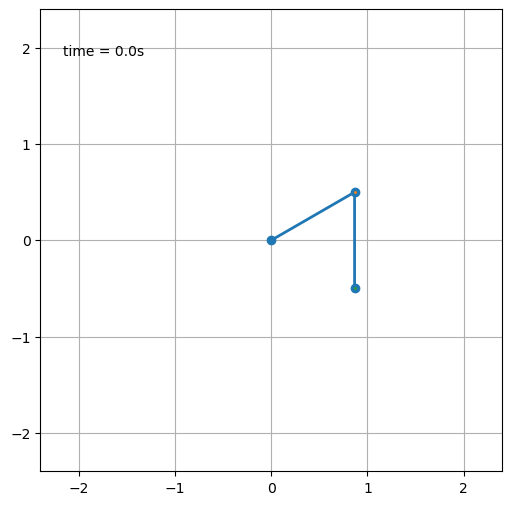

In [7]:
#%matplotlib notebook
l1 = 1.
l2 = 1.
m1 = 1.
m2 = 1.
xi1 = 120.
xi2 = 0.
xi3 = 0.
xi4 = 0.
met = "runge_kutta"

x1, y1, x2, y2, t, dt, fig = main(l1,l2,m1,m2, xi1,xi2,xi3,xi4, method = met, plot=False)

fig  = plt.figure(figsize=(8, 6), dpi=100)
fig_limits = (l1+l2)*1.2
ax   = fig.add_subplot(xlim=(-fig_limits, fig_limits), ylim=(-fig_limits, fig_limits))
ax.set_aspect('equal')
ax.grid()
fps  = 20
hist_len = 500

line,   = ax.plot([], [], 'o-', lw=2)
trace1, = ax.plot([], [], '.-', lw=1, ms=2)
trace2, = ax.plot([], [], '.-', lw=1, ms=2)
time    = ax.text(0.05,0.9, '', transform = ax.transAxes)
tracex1, tracey1 = deque(maxlen=hist_len), deque(maxlen=hist_len)
tracex2, tracey2 = deque(maxlen=hist_len), deque(maxlen=hist_len)

anim = animation.FuncAnimation(fig, animate, frames=5000, 
                               interval=dt/200, 
                               blit=True)
plt.show()

# Last word
For the detailed derivation of the solutions and an interactive solutions and visualizations of the double pendulum system, there is a great website tutorial by myPhysicsLab.com https://www.myphysicslab.com/pendulum/double-pendulum-en.html. 